In [12]:
import copy
import os
import numpy as np
import csv
import numpy as np
import argparse

import json
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from matplotlib import ticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from set_analyze.my_diff_color import *

from cache_sensitive_names import *

cache_type = 'goldencove'

select_json = f'/nfs/home/zhangchuanqi/lvna/5g/lazycat-data_proc/set_analyze/conf-json/conf_{cache_type}_tailbm50M.json'

with open(select_json,'r') as f:
        use_conf = json.load(f)

test_prefix = use_conf['test_prefix']
perf_prefix = '95perf'
pic_dir_path = f'{test_prefix}pics'

ncore = 4
napps = 2
app_labels = ['HP','BE']

work0names = use_conf['cache_work_names']


print(work0names)

xlsx_file = f'/nfs/home/zhangchuanqi/lvna/5g/lazycat-data_proc/set_analyze/asplos23-{test_prefix}allpolicy.xlsx'

all_sheets = pd.read_excel(xlsx_file, sheet_name=None)

# w0s = ["astar_biglakes", "xalancbmk","omnetpp","gcc_200","soplex_pds","gcc_cpdecl","sphinx3",
#  "cactusADM", "gcc_g23", "mcf", "gcc_scilab", "lbm",]
w0s = work0names

parameters = {'axes.labelsize': 25,
        'axes.titlesize': 30,
        'xtick.labelsize': 28,
        'ytick.labelsize': 24,
        'legend.fontsize': 28,
        'font.size': 45,
        'lines.linewidth': 3,
        }
plt.rcParams.update(parameters)
fig_inchs = (20,8)

['cam4', 'cc_sv', 'fotonik3d', 'imgdnn', 'lbm', 'omnetpp', 'parest', 'pr_spmv', 'roms', 'sphinx', 'tc', 'xalancbmk', 'xapian']


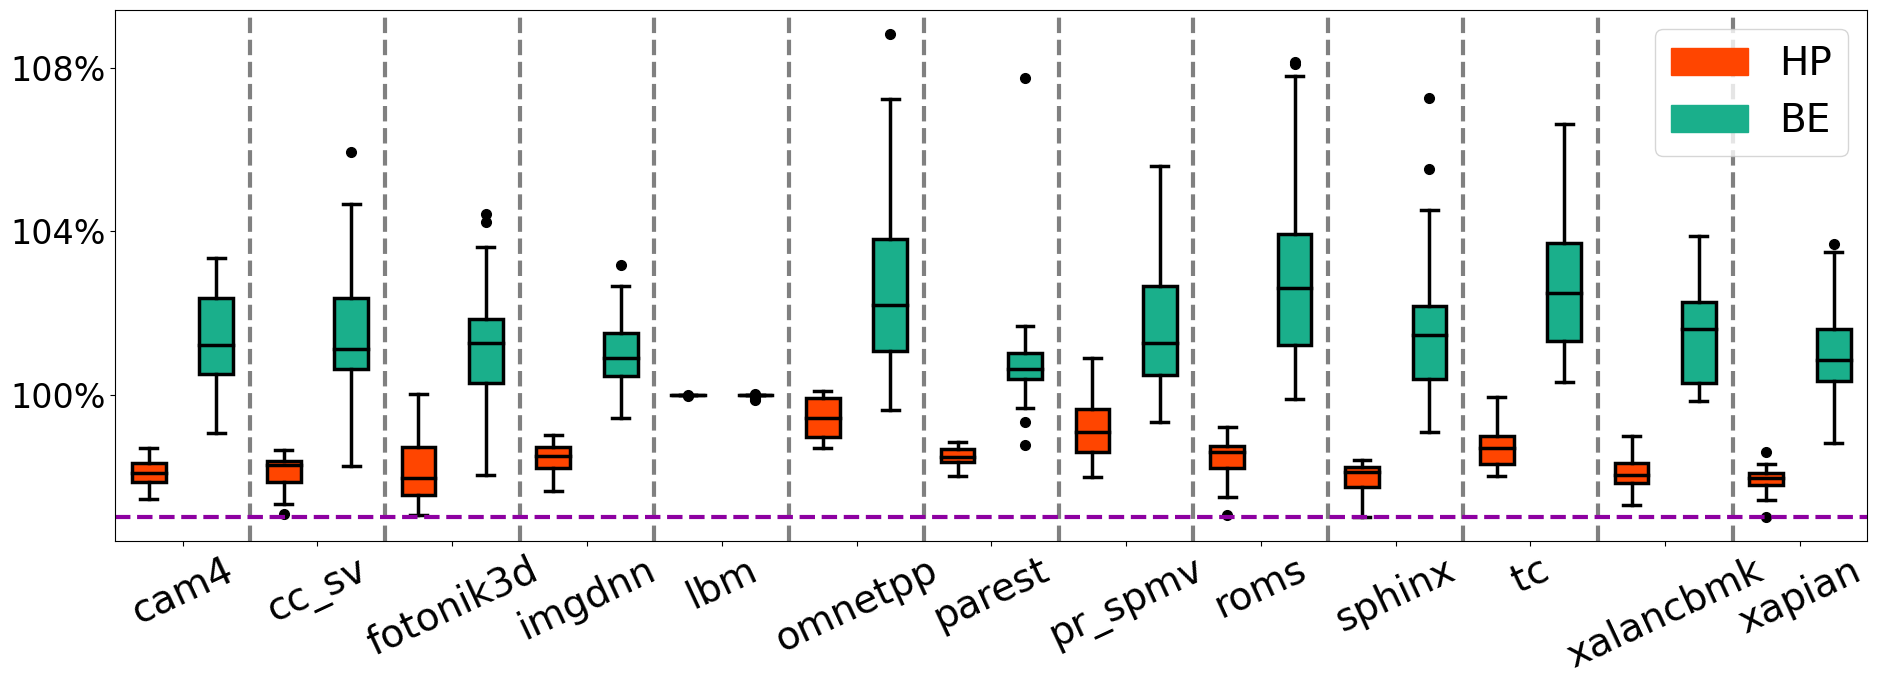

In [11]:


sheet32 = all_sheets['32bucket']

gsheet32 = sheet32.groupby('workload0')

expf = 'realOneWithTarget{}_speedup{}'
# compare cpu0 and other cpus
exps = [expf.format('0.97', i) for i in range(ncore)]

data = []

for w0 in w0s:
    bar0 = gsheet32.get_group(w0)[exps[0]].values
    data.append(bar0)

    be_datas = []
    for c in range(1, ncore):
        be_datas.append(gsheet32.get_group(w0)[exps[c]].values)
    # concatenate all other BEs
    be_datas = np.concatenate(be_datas)
    # average the BE combination
    # be_datas = np.average(be_datas, axis=0)
    data.append(be_datas)

# draw boxplots
fig, ax = plt.subplots()
bp = ax.boxplot(data, showfliers=True, patch_artist=True,
                capprops=dict(color='black', linewidth=2.5),
                whiskerprops=dict(color='black', linewidth=2.5),
                boxprops=dict(color='black', linewidth=2.5),
                meanprops=dict(color='black', linewidth=2.5),
                medianprops=dict(color='black', linewidth=2.5),
                flierprops=dict(
                    marker='o',
                    markerfacecolor='black', linewidth=10, markersize=7, markeredgecolor='black'))

box_step = 2


# set box colors alternatively
colors = contrasting_orange
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i % box_step])

# set vlines to separate different workloads
for i in range(1, len(w0s)):
    ax.axvline(x=box_step*i+0.5, color='gray',linewidth=3, linestyle='--')

ax.axhline(y=0.97, color='#8D00A1',linewidth=3, linestyle='--')

# set xlabels
xlabel0_val = np.average(np.arange(1, box_step+1))
ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(w0s))])
ax.set_xticklabels(w0s)

plt.setp(ax.get_xticklabels(), rotation=25, ha="center",
        # rotation_mode="anchor")
        rotation_mode="default")

# ax.set_yticks(MultipleLocator)
# ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.04))

# set legend
legends = [Patch(color=contrasting_orange[i],label=f'{app_labels[i]}')
                    for i in range(2)]
# legends = [ Line2D([0], [0], color=colors[0], lw=2, label='16 Buckets'),
#             Line2D([0], [0], color=colors[1], lw=2, label='32 Buckets'),
#             Line2D([0], [0], color=colors[2], lw=2, label='64 Buckets')]
plt.legend(handles = legends)
# plt.title(exps[0])
fig.set_size_inches(fig_inchs)
fig.tight_layout()
# plt.show()
plt.savefig(f'{pic_dir_path}/asplos23_boxplot_overall_97.png', dpi=300)

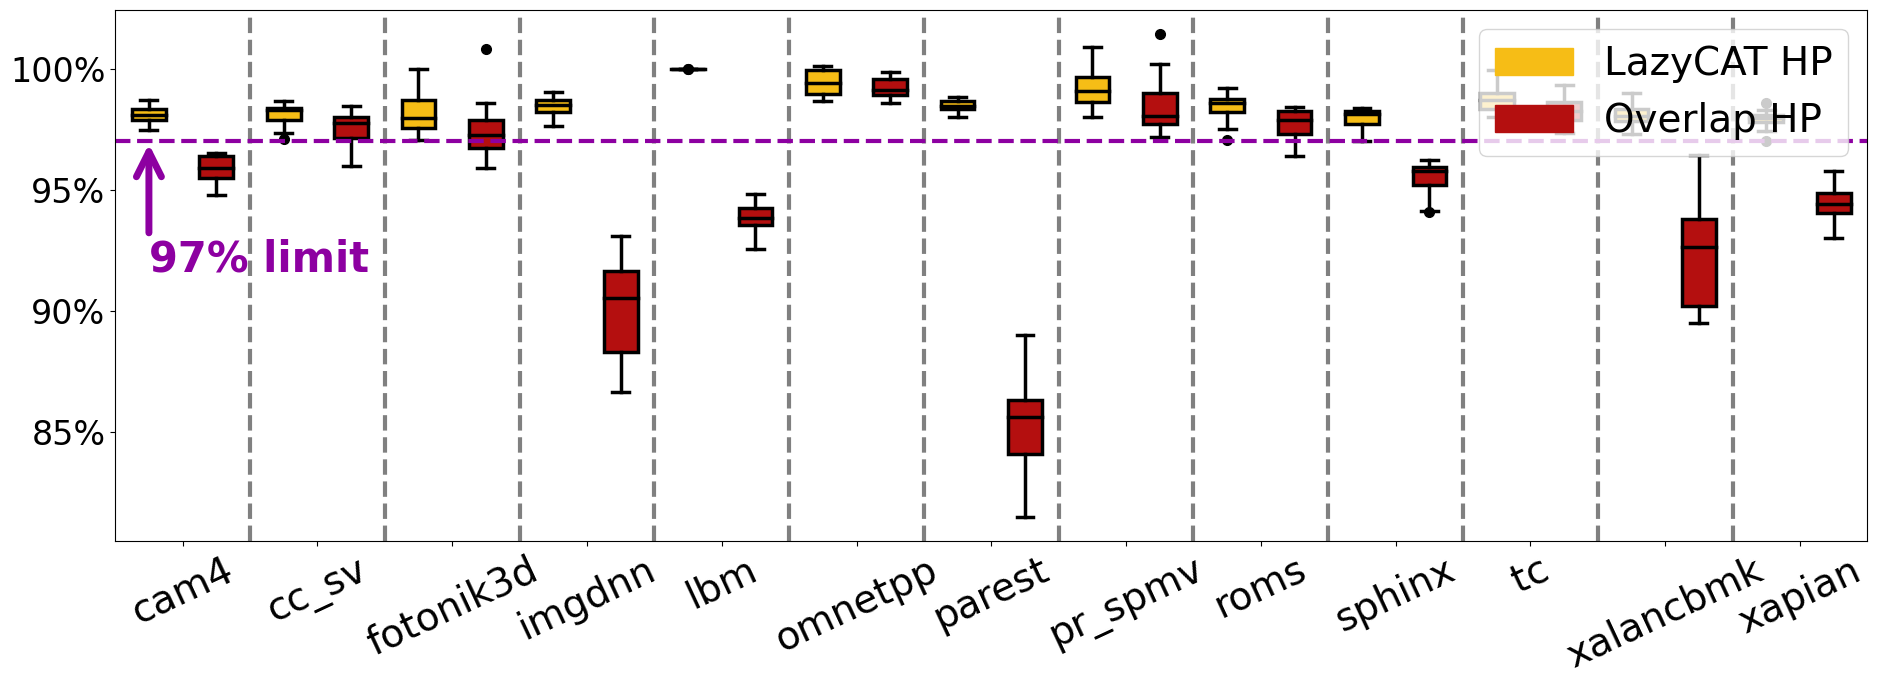

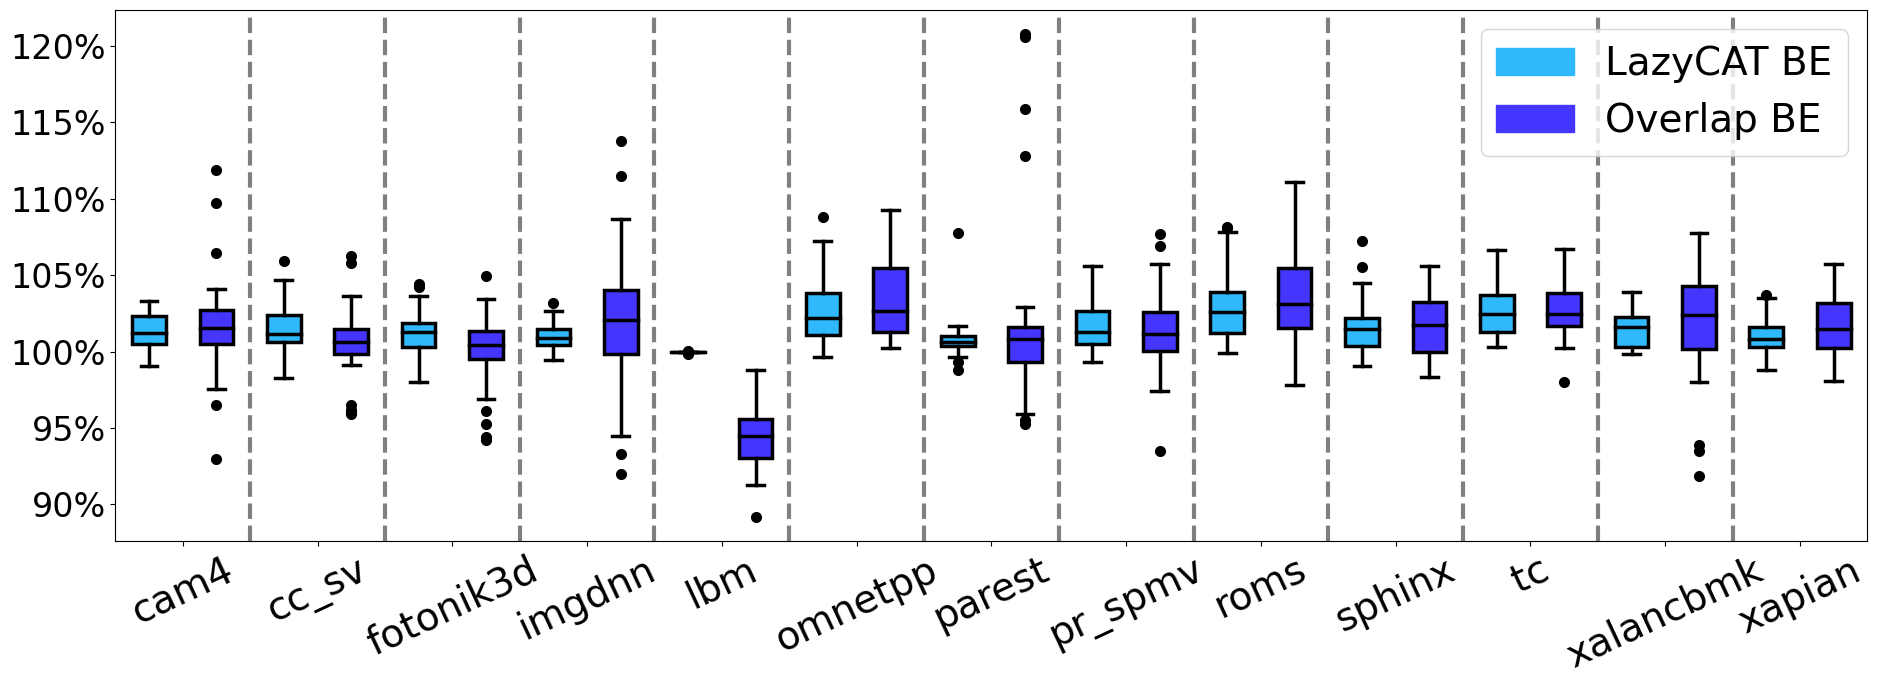

In [13]:

# w0s = ["astar_biglakes", "xalancbmk","omnetpp","gcc_200","soplex_pds","gcc_cpdecl","sphinx3",
#  "cactusADM", "gcc_g23", "mcf", "gcc_scilab", "lbm",]


sheet32 = all_sheets['32bucket']

gsheet32 = sheet32.groupby('workload0')

expf = 'realOneWithTarget{}_speedup{}'
overl_f = 'OverlapOne_speedup{}'

data_apps = [list() for _ in range(napps)]
lazy_exps = [expf.format('0.97', corei) for corei in range(ncore)]
overl_exps = [overl_f.format(corei) for corei in range(ncore)]

for w0 in w0s:
    bar0 = gsheet32.get_group(w0)[lazy_exps[0]].values
    data_apps[0].append(bar0)

    bar0 = gsheet32.get_group(w0)[overl_exps[0]].values
    data_apps[0].append(bar0)

    be_datas = []
    for c in range(1, ncore):
        be_datas.append(gsheet32.get_group(w0)[lazy_exps[c]].values)
    # concatenate all other BEs
    be_datas = np.concatenate(be_datas)
    # average the BE combination
    # be_datas = np.average(be_datas, axis=0)
    data_apps[1].append(be_datas)

    be_datas = []
    for c in range(1, ncore):
        be_datas.append(gsheet32.get_group(w0)[overl_exps[c]].values)
    # concatenate all other BEs
    be_datas = np.concatenate(be_datas)
    # average the BE combination
    # be_datas = np.average(be_datas, axis=0)
    data_apps[1].append(be_datas)

for appi in range(len(app_labels)):
    box_step = 2
    # draw boxplots
    fig, ax = plt.subplots()
    bp = ax.boxplot(data_apps[appi], showfliers=True, patch_artist=True,
                    capprops=dict(color='black', linewidth=2.5),
                    whiskerprops=dict(color='black', linewidth=2.5),
                    boxprops=dict(color='black', linewidth=2.5),
                    meanprops=dict(color='black', linewidth=2.5),
                    medianprops=dict(color='black', linewidth=2.5),
                    flierprops=dict(
                        marker='o',
                        markerfacecolor='black', linewidth=10, markersize=7, markeredgecolor='black'))

    # set box colors alternatively
    colors = contrasting_orange[3+2*appi:]
    for i, box in enumerate(bp['boxes']):
        box.set_facecolor(colors[i % box_step])

    # set vlines to separate different workloads
    for i in range(1, len(w0s)):
        ax.axvline(x=box_step*i+0.5, color='gray',linewidth=3, linestyle='--')
    
    if appi == 0:
        ax.axhline(y=0.97, color='#8D00A1',linewidth=3, linestyle='--')
        ax.annotate( '', xy=(1, 0.97), xytext=(1, 0.931),
              arrowprops=dict(arrowstyle="->", linewidth=5 ,facecolor='#8D00A1',ec='#8D00A1') )
        ax.annotate( '97% limit', xy=(1, 0.93),color='#8D00A1',fontsize = 30,
                    xytext=(1, 0.93) , va = "top", ha="left" ,fontweight='bold')
        # ax.annotate('97% target', (1, 0.97), color='#8D00A1',
        #     xytext=(3, 0.92),
        #     arrowprops=dict(facecolor='#8D00A1',ec='#8D00A1', shrink=0.2),
        #     fontsize=18,fontweight='bold',
        #     horizontalalignment='center', verticalalignment='top')
        # ax.annotate('97% target', xy=(1, 0.97), xytext=(1.1, 0.97),)
        # ax.arrow(1, 0.93, 0, 0.04,length_includes_head=True,shape="right", width=0.2, fc='#8D00A1', ec='#8D00A1')

    # set xlabels
    xlabel0_val = np.average(np.arange(1, box_step+1))
    ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(w0s))])
    ax.set_xticklabels(w0s)

    plt.setp(ax.get_xticklabels(), rotation=25, ha="center",
            # rotation_mode="anchor")
            rotation_mode="default")

    # ax.set_yticks(MultipleLocator)
    # ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))

    # set legend
    legends = [Patch(color=colors[0],label=f'LazyCAT {app_labels[appi]}'),
                    Patch(color=colors[1],label=f'Overlap {app_labels[appi]}')]
    plt.legend(handles = legends,loc='upper right')
    # plt.title(exps[0])
    fig.set_size_inches(fig_inchs)
    fig.tight_layout()
    # plt.show()
    plt.savefig(f'{pic_dir_path}/asplos23_boxplot_compare_overlap_{app_labels[appi]}.png', dpi=300)

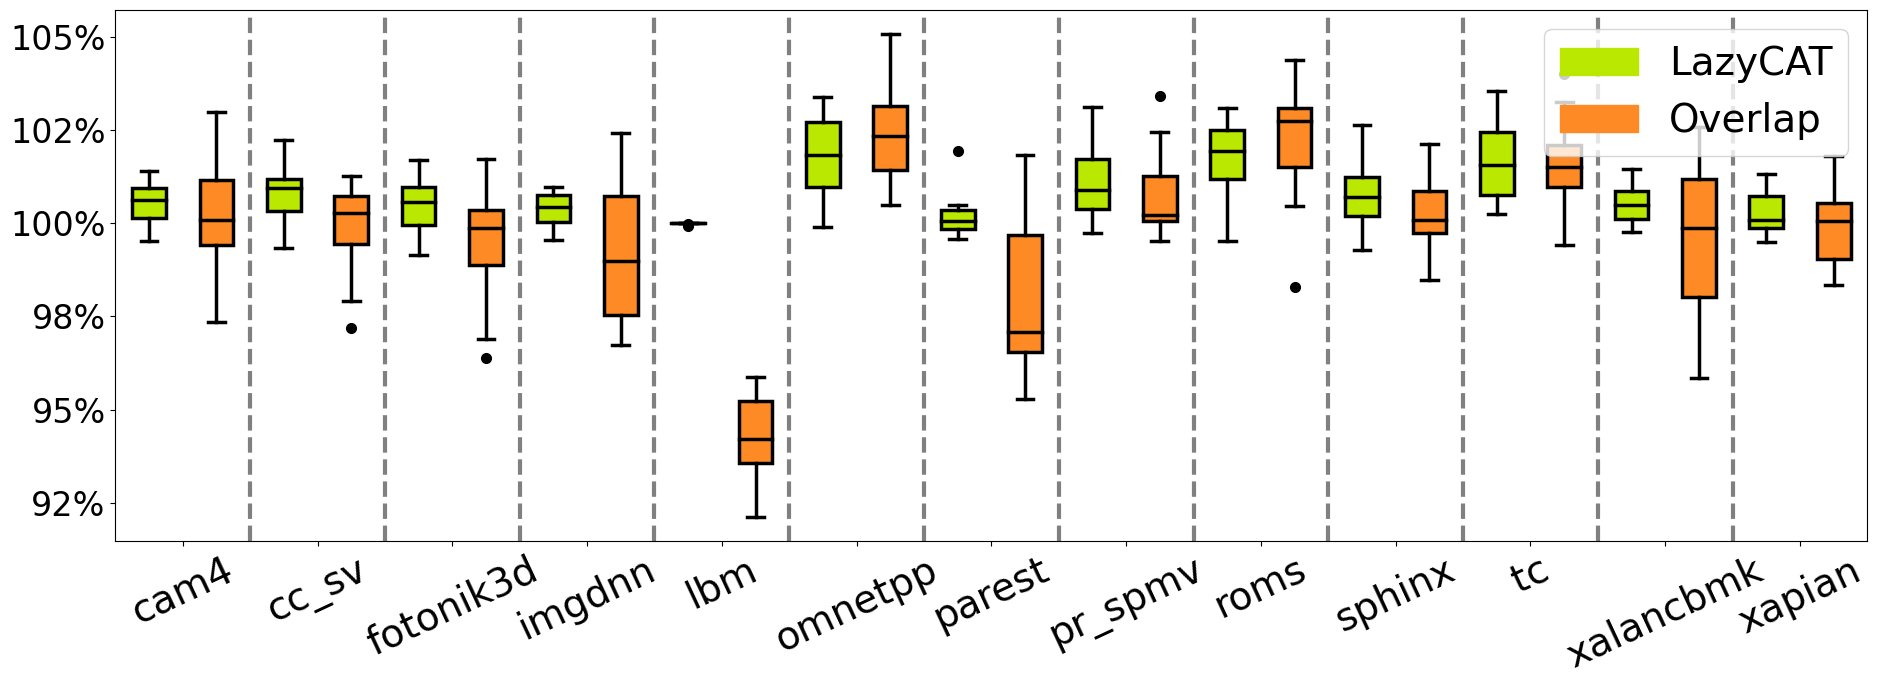

In [22]:


sheet32 = all_sheets['32bucket']

gsheet32 = sheet32.groupby('workload0')

expf = 'realOneWithTarget{}_speedup{}'
overl_f = 'OverlapOne_speedup{}'

# data_apps = [list() for _ in range(napps)]
throughput_all = []
lazy_exps = [expf.format('0.97', corei) for corei in range(ncore)]
overl_exps = [overl_f.format(corei) for corei in range(ncore)]

policy_use_exps = [lazy_exps, overl_exps]

for w0 in w0s:
    for select_exps in policy_use_exps:
        hpbe_datas = []
        for c in range(0, ncore):
            hpbe_datas.append(gsheet32.get_group(w0)[select_exps[c]].values)
        # average the throughput of all HP and BE combinations
        hpbe_datas = np.average(hpbe_datas, axis=0)
        throughput_all.append(hpbe_datas)

box_step = 2
# draw boxplots
fig, ax = plt.subplots()
bp = ax.boxplot(throughput_all, showfliers=True, patch_artist=True,
                capprops=dict(color='black', linewidth=2.5),
                whiskerprops=dict(color='black', linewidth=2.5),
                boxprops=dict(color='black', linewidth=2.5),
                meanprops=dict(color='black', linewidth=2.5),
                medianprops=dict(color='black', linewidth=2.5),
                flierprops=dict(
                    marker='o',
                    markerfacecolor='black', linewidth=10, markersize=7, markeredgecolor='black'))

# set box colors alternatively
colors = contrasting_orange[8:]
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i % box_step])

# set vlines to separate different workloads
for i in range(1, len(w0s)):
    ax.axvline(x=box_step*i+0.5, color='gray',linewidth=3, linestyle='--')

# set xlabels
xlabel0_val = np.average(np.arange(1, box_step+1))
ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(w0s))])
ax.set_xticklabels(w0s)

plt.setp(ax.get_xticklabels(), rotation=25, ha="center",
        # rotation_mode="anchor")
        rotation_mode="default")

# ax.set_yticks(MultipleLocator)
# ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))

# set legend
legends = [Patch(color=colors[0],label=f'LazyCAT'),
                Patch(color=colors[1],label=f'Overlap')]
plt.legend(handles = legends,loc='upper right')
# plt.title(exps[0])
fig.set_size_inches(fig_inchs)
fig.tight_layout()
# plt.show()
plt.savefig(f'{pic_dir_path}/asplos23_boxplot_compare_overlap_WeightedSpeedup.png', dpi=300)

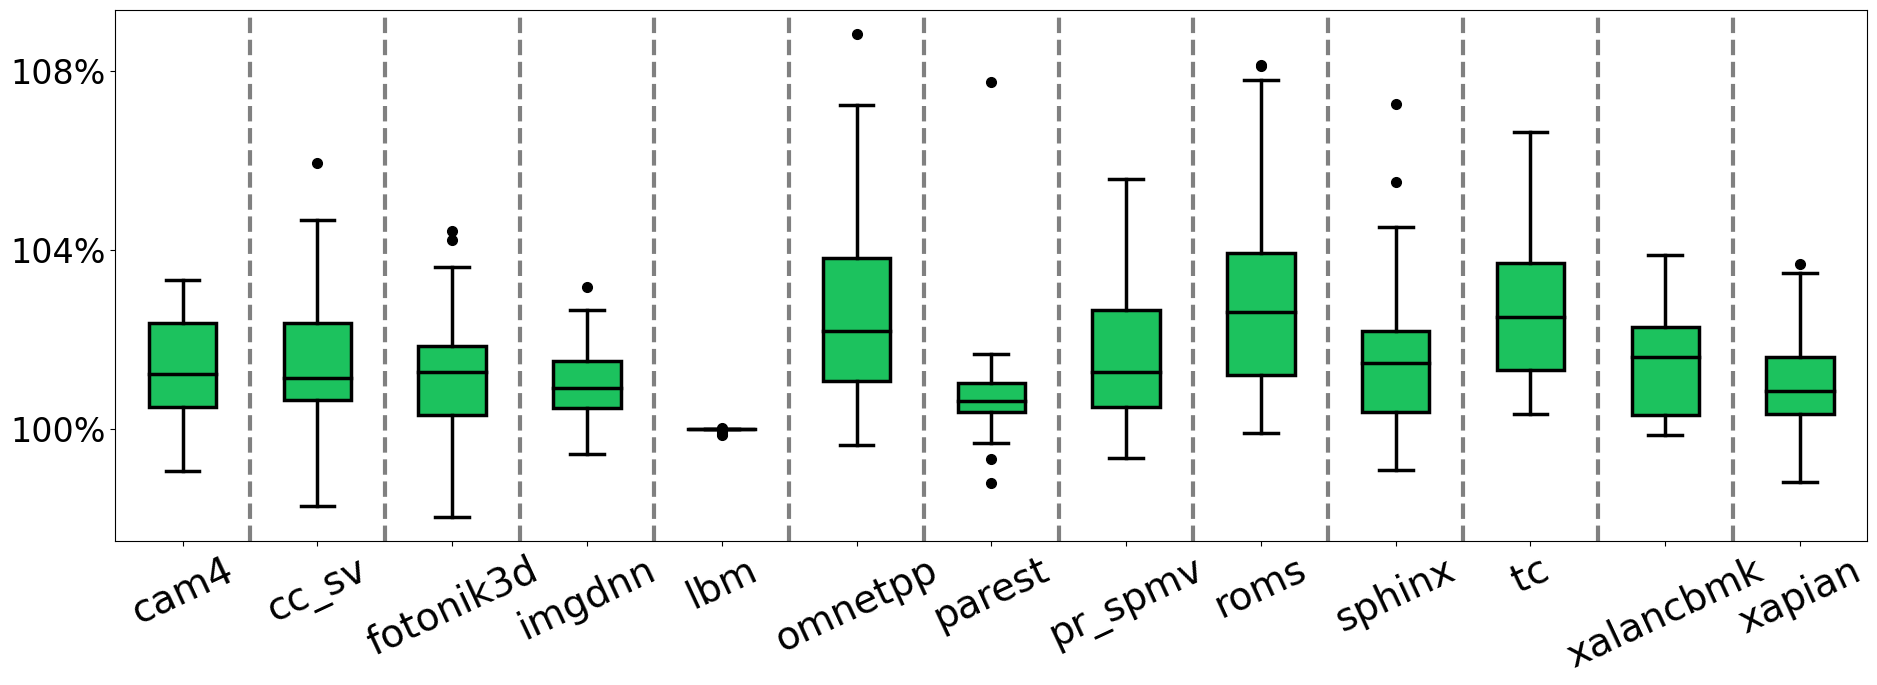

In [18]:

sheet32 = all_sheets['32bucket']

gsheets = [sheet32.groupby(f'workload{c}') for c in range(1, ncore)]

expf = 'realOneWithTarget{}_speedup{}'
# compare cpu0 and cpu1
exps = [expf.format('0.97', c) for c in range(1, ncore)]

data = []

for w0 in w0s:
    tmp_be_datas = []
    for gs,e in zip(gsheets, exps):
        bar = gsheet32.get_group(w0)[e].values
        tmp_be_datas.append(bar)
    data.append(np.concatenate(tmp_be_datas))

# draw boxplots
fig, ax = plt.subplots()
bp = ax.boxplot(data, showfliers=True, patch_artist=True,
                capprops=dict(color='black', linewidth=2.5),
                whiskerprops=dict(color='black', linewidth=2.5),
                boxprops=dict(color='black', linewidth=2.5),
                meanprops=dict(color='black', linewidth=2.5),
                medianprops=dict(color='black', linewidth=2.5),
                flierprops=dict(
                    marker='o',
                    markerfacecolor='black', linewidth=10, markersize=7, markeredgecolor='black'))

box_step = 1


# set box colors alternatively
colors = [
'#1CC25E',
'#946DFF',
'#6C3E00',
'#6193FF',
'#FF988E',
'#36BCCB',]
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i % box_step])

# set vlines to separate different workloads
for i in range(1, len(w0s)):
    ax.axvline(x=box_step*i+0.5, color='gray',linewidth=3, linestyle='--')

# set xlabels
xlabel0_val = np.average(np.arange(1, box_step+1))
ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(w0s))])
ax.set_xticklabels(w0s)


plt.setp(ax.get_xticklabels(), rotation=25, ha="center",
        # rotation_mode="anchor")
        rotation_mode="default")

# ax.set_yticks(MultipleLocator)
# ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.04))

# set legend
# legends = [Patch(color=colors[0],label=f'core1 speedup')]
# legends = [ Line2D([0], [0], color=colors[0], lw=2, label='16 Buckets'),
#             Line2D([0], [0], color=colors[1], lw=2, label='32 Buckets'),
#             Line2D([0], [0], color=colors[2], lw=2, label='64 Buckets')]
# plt.legend(handles = legends)
# plt.title(exps[0])
fig.set_size_inches(fig_inchs)
fig.tight_layout()
# plt.show()
plt.savefig(f'{pic_dir_path}/asplos23_boxplot_accepter_97.png', dpi=300)

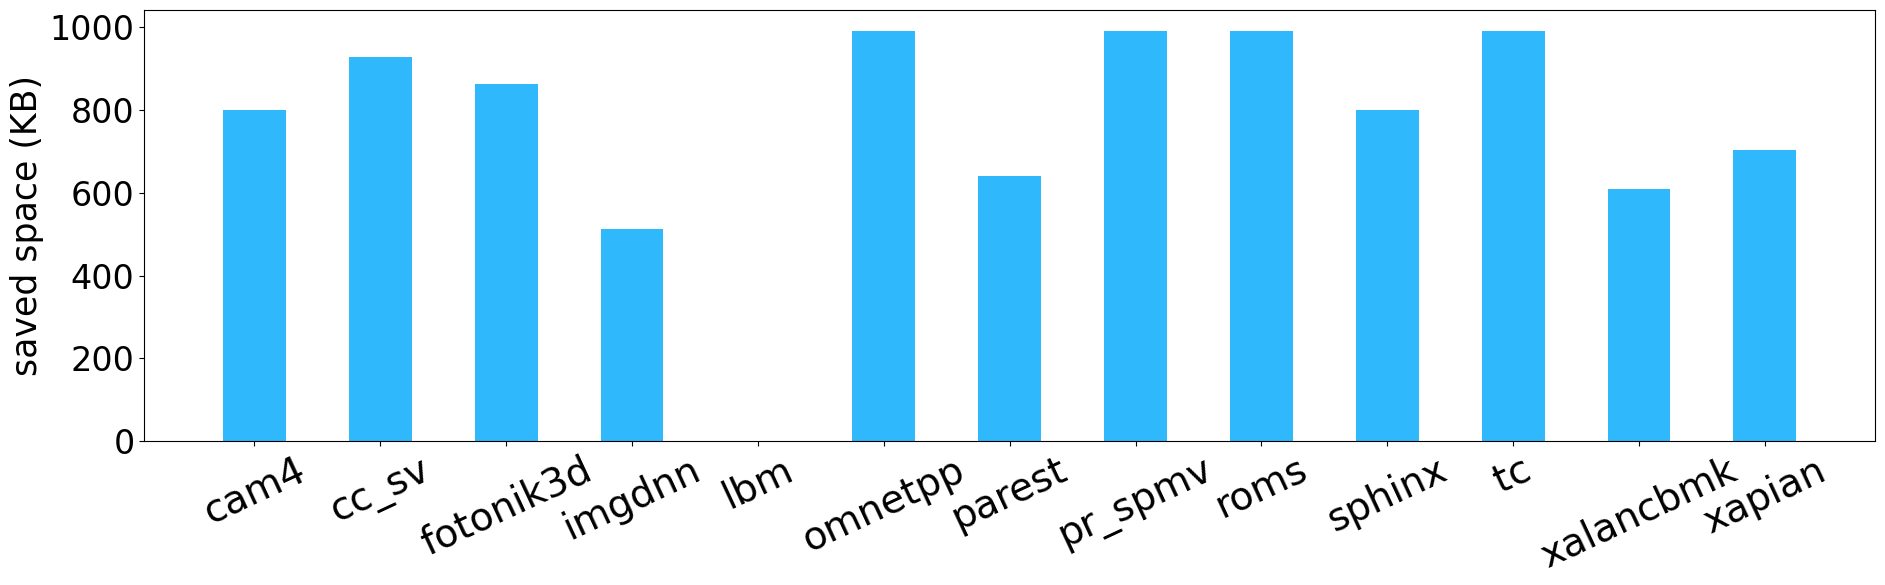

In [17]:
sheet32 = all_sheets['32_target_0.97_in64']

data = []

all_set = use_conf['all_set']

for w0 in w0s:
    target = sheet32[w0].values[0]
    save_space = (64 - target) * (all_set // 64) * 64 // 1024
    data.append(save_space)


# draw boxplots
fig, ax = plt.subplots()

colors = [
'#1CC25E',
'#946DFF',
'#6C3E00',
'#6193FF',
'#FF988E',
'#36BCCB',]

bcolor = '#2FB8FC'

b = ax.bar(np.arange(1,len(w0s)+1) ,data, color=bcolor, width=0.5)

box_step = 1
# set xlabels
xlabel0_val = np.average(np.arange(1, box_step+1))
ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(w0s))])
ax.set_xticklabels(w0s)


plt.setp(ax.get_xticklabels(), rotation=25, ha="center",
        # rotation_mode="anchor")
        rotation_mode="default")

# ax.set_yticks(MultipleLocator)
# ax.set_ylim(0, 1)
# ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax.set_ylabel('saved space (KB)')
# set legend
# legends = [Patch(color=bcolor,label=f'saved space (KB)')]
# legends = [ Line2D([0], [0], color=colors[0], lw=2, label='16 Buckets'),
#             Line2D([0], [0], color=colors[1], lw=2, label='32 Buckets'),
#             Line2D([0], [0], color=colors[2], lw=2, label='64 Buckets')]
# plt.legend(handles = legends)
# plt.title(exps[0])
fig.set_size_inches(20, 7)
fig.tight_layout()
# plt.show()
plt.savefig(f'{pic_dir_path}/asplos23_bar_savedspace_32bucket_97.png', dpi=300)

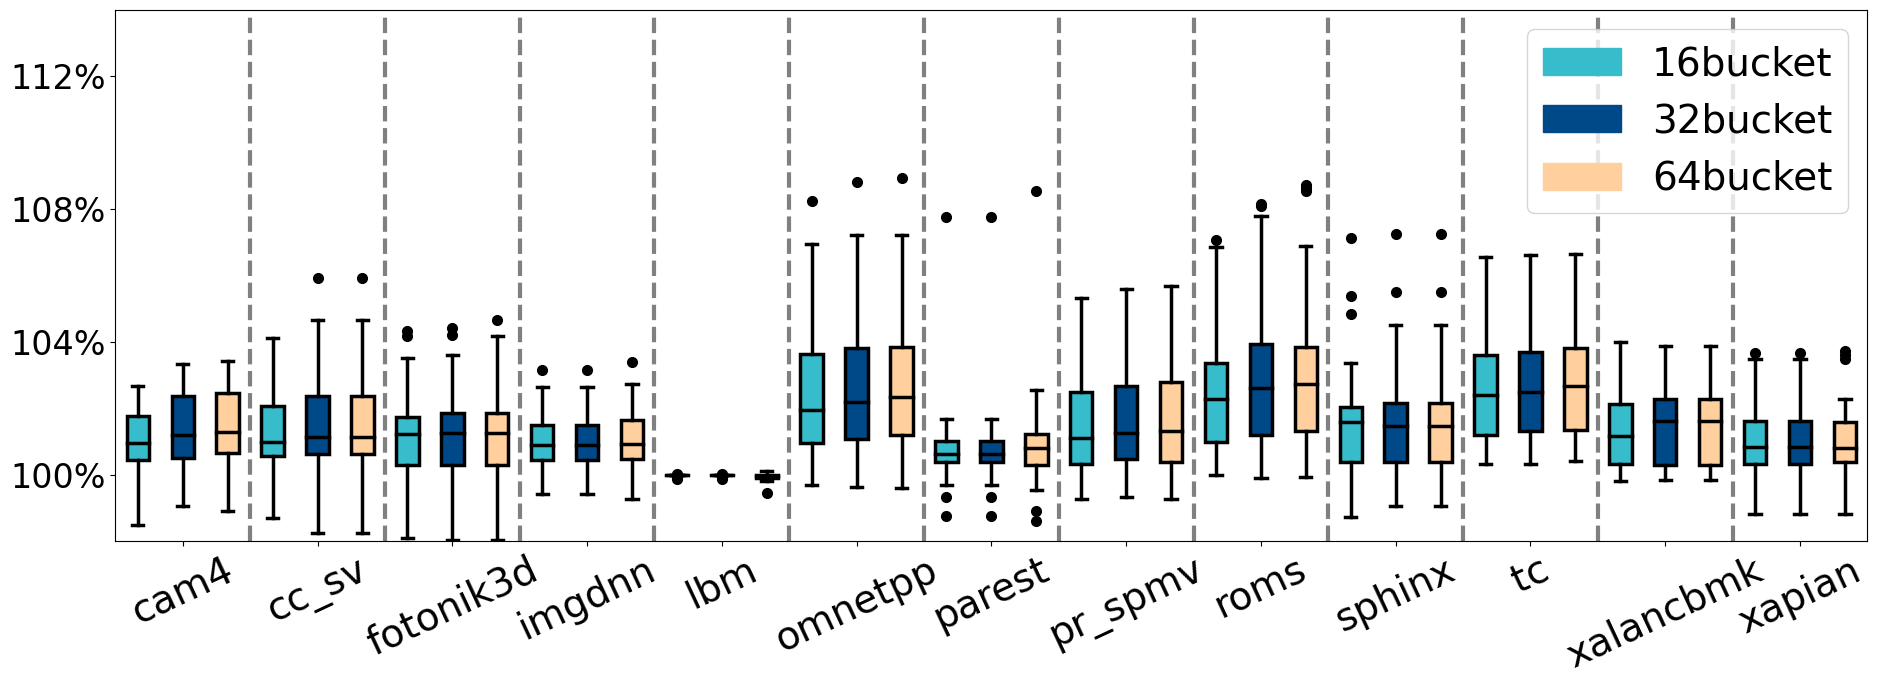

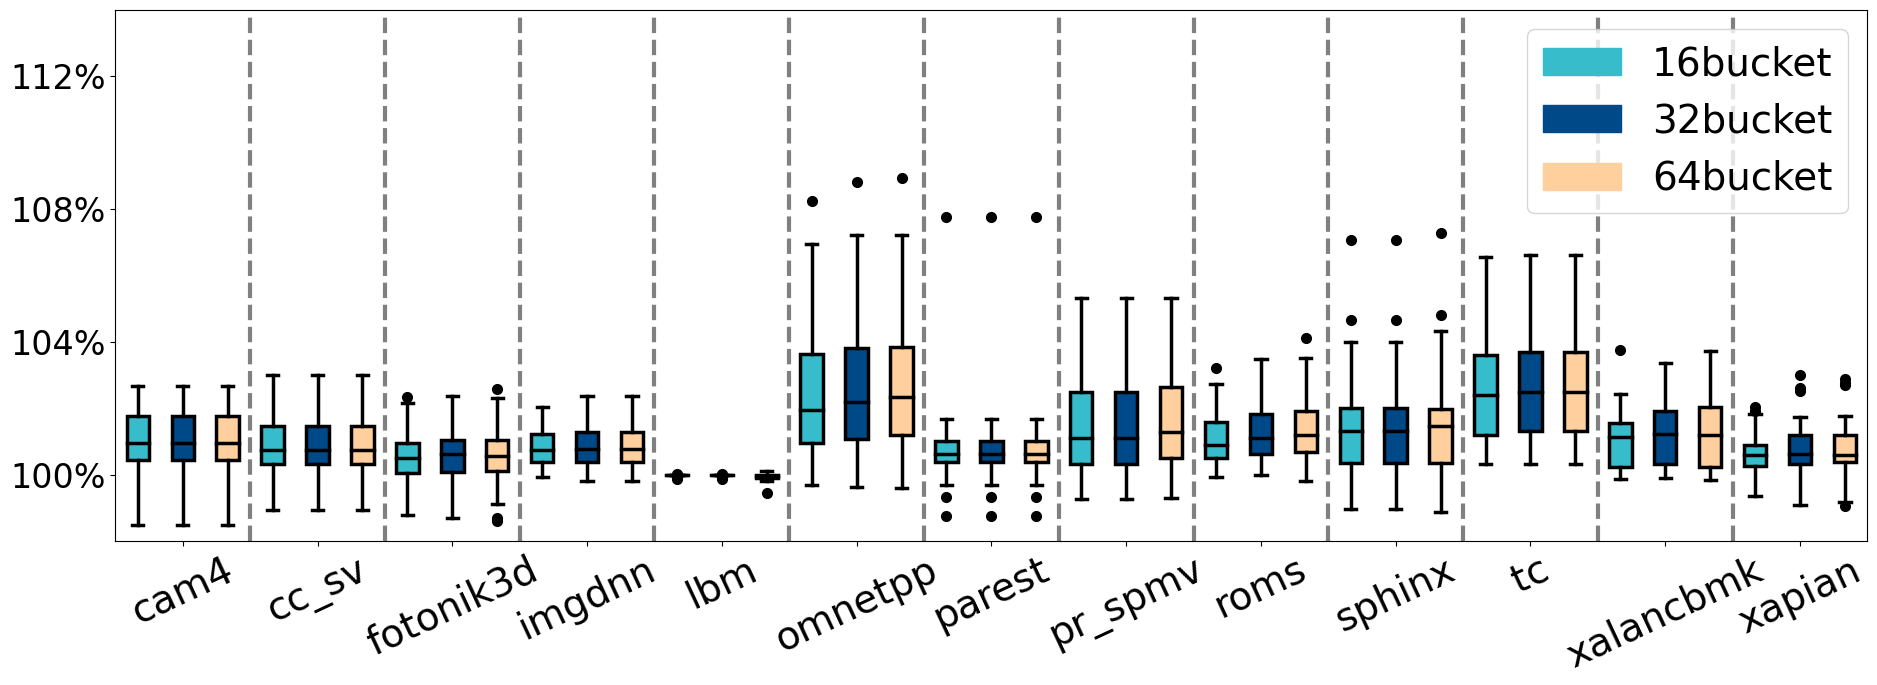

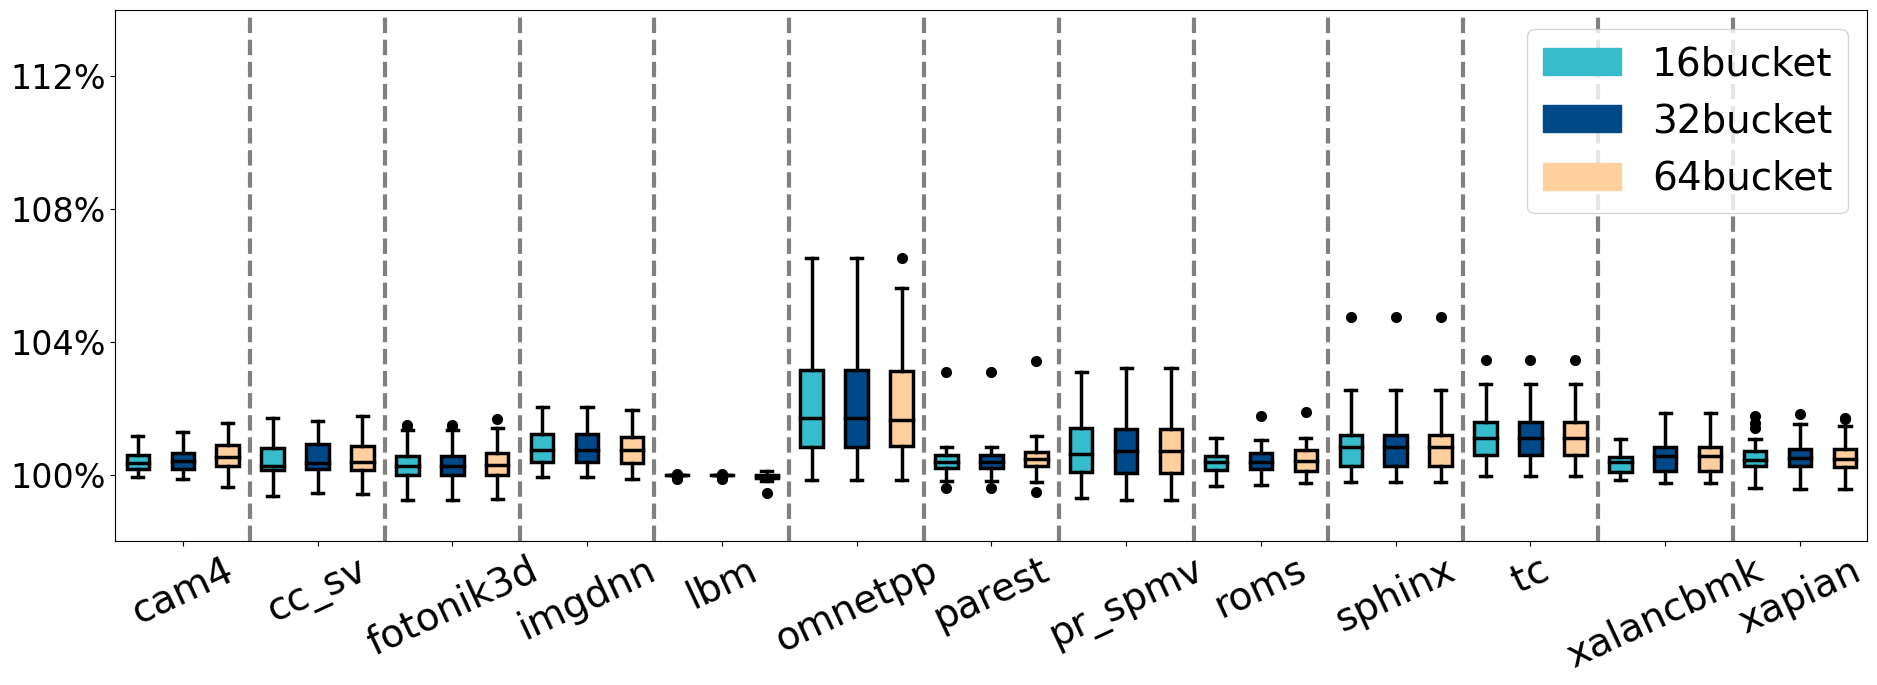

In [21]:
bucket_list = ['16bucket', '32bucket', '64bucket']

mb_sheets = [ all_sheets[bucket].groupby("workload0") for bucket in bucket_list ]

target = ['0.97','0.98','0.99']
for ts in target:
    exp = [f'realOneWithTarget{ts}_speedup{c}' for c in range(1,ncore)]
    data = []
    for w0 in w0s:
        for grouped in mb_sheets:
            be_datas = []
            for e in exp:
                be_datas.append(grouped.get_group(w0)[e].values)
            data.append(np.concatenate(be_datas))

    # draw boxplots
    fig, ax = plt.subplots()
    bp = ax.boxplot(data, showfliers=True, patch_artist=True,
            capprops=dict(color='black', linewidth=2.5),
            whiskerprops=dict(color='black', linewidth=2.5),
            boxprops=dict(color='black', linewidth=2.5),
            meanprops=dict(color='black', linewidth=2.5),
            medianprops=dict(color='black', linewidth=2.5),
            flierprops=dict(
                marker='o',
                markerfacecolor='black', linewidth=10, markersize=7, markeredgecolor='black'))

    box_step = len(mb_sheets)

    # set box colors alternatively
    colors = ['#36BCCB',
    '#004988',
    '#FFCF9D',]
    for i, box in enumerate(bp['boxes']):
        box.set_facecolor(colors[i % box_step])

    # set vlines to separate different workloads
    for i in range(1, len(w0s)):
        ax.axvline(x=box_step*i+0.5, color='gray',linewidth=3, linestyle='--')

    # set xlabels
    xlabel0_val = np.average(np.arange(1, box_step+1))
    ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(w0s))])
    ax.set_xticklabels(w0s)

    plt.setp(ax.get_xticklabels(), rotation=25, ha="center",
            # rotation_mode="anchor")
            rotation_mode="default")

    # ax.set_yticks(MultipleLocator)
    ax.set_ylim(0.98, 1.14)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.04))

    # set legend
    legends = [Patch(color=colors[i%box_step],label=f'{bucket_list[i]}')
                for i in range(0, box_step) ]
    # legends = [ Line2D([0], [0], color=colors[0], lw=2, label='16 Buckets'),
    #             Line2D([0], [0], color=colors[1], lw=2, label='32 Buckets'),
    #             Line2D([0], [0], color=colors[2], lw=2, label='64 Buckets')]
    plt.legend(handles = legends, loc = 'upper right')
    # plt.title(exps[0])
    fig.set_size_inches(fig_inchs)
    fig.tight_layout()
    # plt.show()
    plt.savefig(f'{pic_dir_path}/asplos23_boxplot_compare_buckets_{ts}.png', dpi=300)
    